[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Eldave93/machine-learning-workbooks/blob/main/06-non-linear_regression_and_regularisation/06_workbook.ipynb)

# Workbook 06 - Non-Linear Regression and Regularisation

by [Dr. David Elliott](https://eldave93.netlify.app/)

Lets start to focus on understanding some regression models. Regression models are used to predict _continuous_ output variables but are generally very flexible (which is why they are so common).

To engage with the workshop material, it is assumed that you have some knowledge of data manipulation and visualisation in Python from previous experience and courses, and worked through workbook 01.

# 1. Workspace Setup
Before downloading any data we should think about our workspace. It is assumed if you have made it this far you have already got your workspace setup. There are two ways of using these notebooks. The first is to use Google Colab, which is a website that allows you to write and execute python code through the browser. The second is a local workspace (e.g. Anaconda).

## 1.A. Google Colab

If you are not using google colab then you can skip this section. 

I have condenced down the setup steps for google colab into a single code block. See the workbook 1 for more of an explanation of whats going on here and what you need to do.

__Note__ 

- Make sure to restart the runtime after installing to ensure everything works correctly. Dont worry it wont need to install again!

In [1]:
import sys

try:
    import google.colab
    import os
    
    COLAB=True
    
    # set the workshop code
    WORKSHOP_NAME = "05-regression"
    # set the folder name
    FOLDER_NAME = "machine-learning-workbooks-main"

    # check if the environment is already setup to avoid repeating this after 
    # restarting the runtime
    if not os.path.exists(FOLDER_NAME) and os.path.exists(FOLDER_NAME+".zip"):
          !unzip "{FOLDER_NAME}.zip"
          
    print("Setting working directory to:")
    %cd "./{FOLDER_NAME}/{WORKSHOP_NAME}"
    
    # install required packages
    !{sys.executable} -m pip install -r ../scripts/requirements.txt
    
except:
    COLAB=False
    print("Colab is not being used")

Colab is not being used


## 1.B. Local Workspace

If your using a local workspace you will need all the packages in the below "Packages" section to run this notebook. If you do not already have them, or you want to ensure you are using the same versions as used when created, the code below (provided `AUTO_INSTALL = True`) will install them for you.
 
__Note__ 

- Make sure to restart the runtime after installing to ensure everything works correctly. Dont worry it wont need to install again!

In [2]:
AUTO_INSTALL = False

if AUTO_INSTALL:
    !{sys.executable} -m pip install -r ../scripts/requirements.txt

## 1.1. Packages

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import sys

sys.path.append('../scripts') # add scripts to the path for use later
sns.set(rc={'figure.figsize': (14, 8)}) # For plot sizes
np.random.seed(42)  # to make this notebook's output identical at every run

## 1.2. Displaying solutions

The solutions are activated using a new .txt file which can be put in the workbook folder (e.g. `01-end_to_end`). Please put in a request for access.

If you have access to the solutions, the following cell will create clickable buttons under each exercise, which will allow you to reveal the solutions.

__Notes__

- This method was created by [Charlotte Desvages](https://charlottedesvages.com/).
- This may not work if you don't have the same version of `IPython.display` as the machine that created them:
    ```
    ImportError: cannot import name 'Code' from 'IPython.display' (/usr/local/lib/python3.7/dist-packages/IPython/display.py)
    ```
    If so run the auto-install above or manually run `!pip install ipython==7.20`.

In [4]:
%run ../scripts/create_widgets.py 05

<IPython.core.display.Javascript object>

Buttons created!


---

# 2. Problem Understanding <a id='problem'></a>

We'll be working with a dataset from Capital Bikeshare that was used in a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/). The objective of the competition was to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

## 2.1. Data Download

We could read the data in from Kaggle (see notebook 2 for an example), but for now lets just read it in using the data stored in the "Data" folder.

In [5]:
bikes = pd.read_csv('./Data/bikeshare.csv')

bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


---

# 3. Data Preparation  <a id='prep'></a>

This data could do with a little cleaning up before we start to explore it. I made a helper function to do this cleaning above so I'll run the data through this just in case you struggled.

In [6]:
from helper_functions import bike_data_prep
bikes = bike_data_prep(pd.read_csv('./data/bikeshare.csv'))
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   realfeel    10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   riders      10886 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 850.5 KB


---
We have another important preparation step to do, split our data into training and test sets! As our data is a time series, it does make sense to try account for this order in how we split up our data.

For our test set in this workbook, we could split the data at some point and use the first chunk for training and second for testing.

We'll make our test set roughly the last business quarter (Q4 2013).

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(bikes,            # data to split
                                     test_size=0.125,  # we will leave 12.5% to test our models on later
                                     random_state=42,  # make our work reproducable 
                                     shuffle=False)    # keep data ordering!

train_df.tail()

,season,holiday,workingday,weather,temp,realfeel,humidity,windspeed,riders
datetime,,,,,,,,,
2012-10-01 01:00:00,4,0,1,1,18.04,21.970,77,6.0032,18
2012-10-01 02:00:00,4,0,1,1,18.86,22.725,72,0.0000,12
2012-10-01 03:00:00,4,0,1,1,18.04,21.970,77,0.0000,7
2012-10-01 04:00:00,4,0,1,1,17.22,21.210,82,7.0015,10
2012-10-01 05:00:00,4,0,1,1,18.04,21.970,77,0.0000,36


In [8]:
test_df.head()

,season,holiday,workingday,weather,temp,realfeel,humidity,windspeed,riders
datetime,,,,,,,,,
2012-10-01 06:00:00,4,0,1,1,18.04,21.970,77,7.0015,155
2012-10-01 07:00:00,4,0,1,1,18.04,21.970,77,11.0014,483
2012-10-01 08:00:00,4,0,1,2,18.86,22.725,77,7.0015,784
2012-10-01 09:00:00,4,0,1,2,21.32,25.000,63,0.0000,340
2012-10-01 10:00:00,4,0,1,1,22.14,25.760,56,0.0000,179


---

# 5. Data Pre-Processing <a id='pre'></a>

Now we have some familiarity with the data though our data exploration, lets start preparing our data to be modelled. 

Lets start by removing `temp` from our training data as we don't need both `temp` and `realfeel`.

In [9]:
train_df.drop("temp", axis=1, inplace=True)

---

# 6. Model Exploration/Refinement <a id='explore'></a>

As we saw in workbook 01, you would normally explore a series of models from different machine learning categories at this stage (e.g. linear, non-linear, forests, neural networks). We would normally do a first pass quickly looking at how different model types do before digging further into them (refinement) - but in this case as we are learning about a particular model in this workbook, it makes sense to blur the line between exploration and refinement here.

Before moving on we are going to split our data again into a training and validation set to ensure we don't keep checking our model performance on the test set. If we keep improving our model based on test set performance this set stops being useful as a measure of future generalisation performance!

In [10]:
output = "riders"

y_train = train_df.loc[:,output]
X_train = train_df.drop(output, axis=1)
feature_names = list(X_train.columns)

print(X_train.shape)
print(y_train.shape)

# Lets keep a copy for when we want them later
X_train_full, y_train_full = X_train.copy(), y_train.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, # data to split
                                                  test_size=0.15,    # we will leave 15% to test our models on later (roughly the last quater)
                                                  random_state=42,   # make our work reproducable 
                                                  shuffle=False)     # prevent data ordering affecting our model

(9525, 7)
(9525,)


### Bias and Variance

We cannot eliminate bias or variance of models, but we can reduce them. Bias and variance often oppose each other- so while you reduce one you may increase the other.

![Bias and Variance](./Images/bias-variance.png)

Bias occurs when we make errors around our model assumptions, for example assuming the data is linear when it is something more complex. Variance on the other hand occurs when the model is overly-sensitive to changes in the data we use to train the model. For example, say you train a model on a particular dataset then later on evaluate a similar dataset the predictions could be wildly different if the variance is high.

To give an example. Imagine you are trying to predict the temperature at any given time, what features would you use to predict this? [Cloud coverage, humidity, time of day, etc]. Let’s say you only build your model using time of day and nothing else. When you train your model you will find that it will always predict the same temperature for 11 o’clock. The variance will be low (consistent prediction) but the bias will be high as the model predictions will probably be miles off from the actual values.

So you make the model more complex and add in a multitude of features, so for each hour of the day for every day of the year you know cloud coverage, humidity, hours of sunshine and so on. For the data you trained the model on, the bias will be low as the model’s predictions will be incredibly close to the real values. However, will the weather now be the exact same this time next year? Probably not, these changes to the data will be picked up by the model leading to wildly inconsistent predictions, or high variance.

In other words, if we want our predictions on our training set to be more reliable then we need to increase model complexity, but this will lead to greater variance when we try to use new data. Simpler models will lead to more consistent predictions, at the cost of less accurate models. We cannot eliminate either issue, but need to find a balance between them.

There are a few ways we can tackle this. To reduce _bias_ we can look into a _nonlinear_ model, to improve _variance_ we could look into _regularization_ techniques. These models are introduced briefly in the extra section of this workbook.

---

## 8.1. Nonlinear Regression

Lets for now return to looking at `realfeel`. In the linear model before we were modelling it linearly as below:

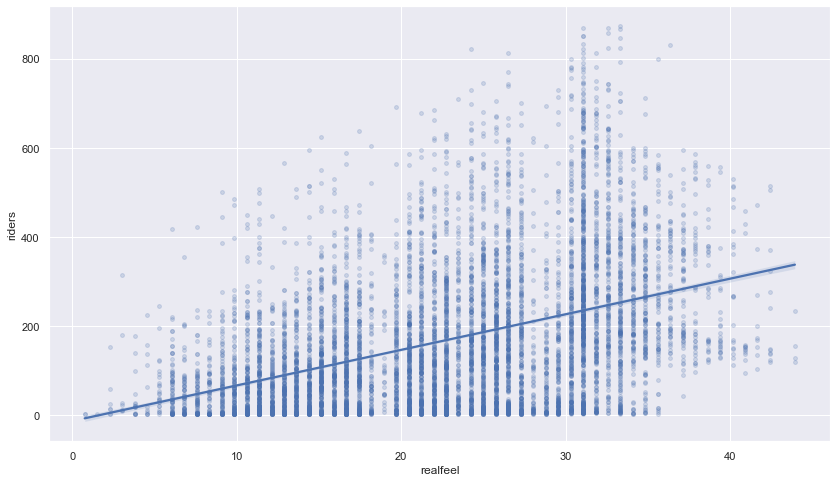

In [11]:
sns.regplot(x=X_train['realfeel'], y=y_train, scatter_kws={"alpha":0.2, "s":15});

However, it may help to allow this line to bend a little to fit the data a little better:

__Note__
- Notice how the confidence interval for the non-linear model (shaded area around the line), is wider. This is actually a good feature as its demonstrating the model is less sure about the values of riders around the upper and lower ends as there is less data there.

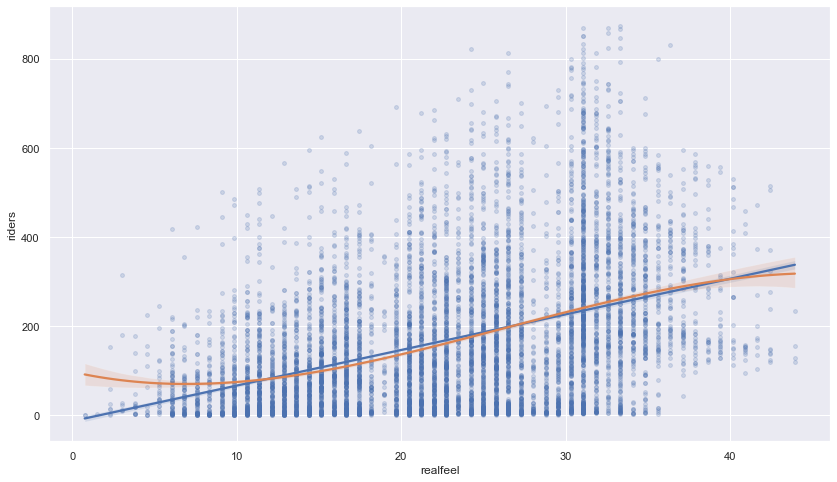

In [12]:
sns.regplot(x=X_train['realfeel'], y=y_train, order=1, scatter_kws={"alpha":0.2, "s":15});
sns.regplot(x=X_train['realfeel'], y=y_train, order=3, scatter=False);

Care should be taken not to overfit a non-linear model to the data though. Lets look back at a smaller set of data to see what I mean.

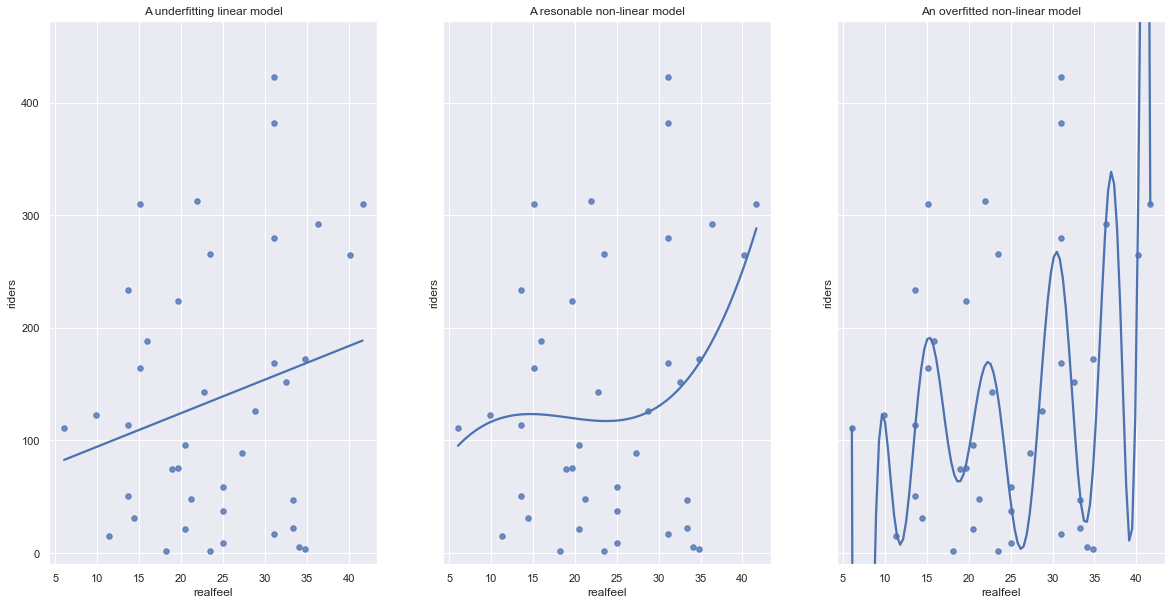

In [13]:
np.random.seed(43)
example = train_df.sample(40)

fig, axes = plt.subplots(figsize = (20,10), ncols=3, sharex=True, sharey=True)

sns.regplot(x=example['realfeel'], y=example['riders'], order=1, 
            scatter_kws={"s":30}, ci=None, ax=axes[0]);
axes[0].set_title("A underfitting linear model")
sns.regplot(x=example['realfeel'], y=example['riders'], order=3, 
            scatter_kws={"s":30}, ci=None, ax=axes[1]);
axes[1].set_title("A resonable non-linear model")
sns.regplot(x=example['realfeel'], y=example['riders'], order=15, 
            scatter_kws={"s":30}, ci=None, ax=axes[2]);
axes[2].set_title("An overfitted non-linear model")

axes[0].set_ylim(-10, example['riders'].max() +50);

Above you see that the first algorithm does not fully capture the sharp rise as `realfeel` increases past 20. However the last algorithm models the noise of the data. Therefore, it has a low bias (the algorithm gets the relevant relationships between the features and the target) but a high variance (models the random noise of the training data). The middle algorithm may therefore be a preferable ballance between the two.

To use non-linear relationships in your scikit-learn models you use `PolynomialFeatures`. This function is included in the *preprocessing* module of sklearn, as with other python functions we can import it as follows.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

Construction and use of this and other transformers is similar to what we have already seen with `LinearRegression`, we construct a `PolynomialFeatures` object in which we set basic options (e.g. the degree of the polynomial) and then apply the transformation to our data via `fit_transform` method. This will generate a new model matrix which includes the polynomial features up to the degree we have specified.

We wont worry about how to calculate the degree, but for our purposes here, the higher the degree the more non-linear it is.

__Notes__
- Generally you will not have need to go over a degree of 3
- This will take longer to fit than linear regression!
- `include_bias=False` just stops the function adding a bias column as our `LinearRegression` object is going to add one for us anyway.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

def extract_hour(dt):
    return dt.hour

def create_hour_feat(data):
    data_ = data.copy()
    data_['hour'] = data_.index.map(extract_hour)
    return data_

# tidy the output into a dataframe
def tidy_scores(score_dict):
    df = pd.DataFrame(score_dict)
    df.loc['mean'] = df.mean()
    df.loc['sd'] = df.std()
    df.rename({"test_r2":"val_r2"}, axis=1, inplace=True)
    df.rename({"test_RMSE":"val_RMSE"}, axis=1, inplace=True)
    df.index.name = "fold"
    return df.round(2)

# make compatible with a scikit-learn pipeline
hour_feat_func = FunctionTransformer(func=create_hour_feat,    # our custom function
                                     validate=False)           # prevents input being changed to numpy arrays

hour_onehot = ColumnTransformer(
    # apply the `OneHotEncoder` to the "hour" column
    [("OHE", OneHotEncoder(drop="first"), ["hour"])],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder="passthrough"
) 

In [27]:
lin_pipe = Pipeline([
    ("create_hour", hour_feat_func),
    ("encode_hr", hour_onehot),
    ("model", LinearRegression())
])

display(lin_pipe)

scores = cross_validate(lin_pipe, 
                        X_train_full[["realfeel"]], y_train_full, 
                        cv=TimeSeriesSplit(n_splits= 7), 
                        scoring = {"r2": make_scorer(r2_score), 
                                   "RMSE": make_scorer(mse, **{"squared":False})},
                        return_train_score=True)
display(tidy_scores(scores))

Pipeline(steps=[('create_hour',
                 FunctionTransformer(func=<function create_hour_feat at 0x000001DE3B263040>)),
                ('encode_hr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour'])])),
                ('model', LinearRegression())])

,fit_time,score_time,val_r2,train_r2,val_RMSE,train_RMSE
fold,,,,,,
0,0.01,0.01,0.29,0.63,110.32,37.41
1,0.01,0.01,0.59,0.64,96.38,65.85
2,0.01,0.01,0.59,0.67,92.07,75.17
3,0.01,0.01,0.48,0.66,85.47,79.18
4,0.01,0.00,0.44,0.64,138.31,79.67
5,0.01,0.00,0.45,0.60,160.29,90.86
6,0.01,0.00,0.51,0.60,161.72,102.10
mean,0.01,0.00,0.48,0.63,120.65,75.75
sd,0.00,0.00,0.10,0.02,30.05,18.97


In [28]:
non_lin_pipe = Pipeline([
    ("create_hour", hour_feat_func),
    ("encode_hr", hour_onehot),
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("model", LinearRegression())
])

display(non_lin_pipe)

scores = cross_validate(non_lin_pipe, 
                        X_train_full[['humidity', "realfeel"]], y_train_full, 
                        cv=TimeSeriesSplit(n_splits= 7), 
                        scoring = {"r2": make_scorer(r2_score), 
                                   "RMSE": make_scorer(mse, **{"squared":False})},
                        return_train_score=True)
display(tidy_scores(scores))

Pipeline(steps=[('create_hour',
                 FunctionTransformer(func=<function create_hour_feat at 0x000001DE3B263040>)),
                ('encode_hr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE',
                                                  OneHotEncoder(drop='first'),
                                                  ['hour'])])),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

,fit_time,score_time,val_r2,train_r2,val_RMSE,train_RMSE
fold,,,,,,
0,0.19,0.00,0.21,0.73,115.86,31.87
1,0.18,0.01,0.70,0.75,81.89,55.14
2,0.25,0.01,0.64,0.77,86.04,62.31
3,0.23,0.01,0.51,0.75,82.83,67.67
4,0.26,0.01,0.51,0.72,129.88,69.52
5,0.24,0.01,0.56,0.69,144.35,80.26
6,0.30,0.01,0.58,0.69,149.47,89.95
mean,0.23,0.01,0.53,0.73,112.90,65.25
sd,0.04,0.00,0.15,0.03,27.28,17.26


...Well it looks like we're doing better on the training data but worse on the validation data. This suggests we have made our overfitting problem even worse!

---

### 🚩 Exercise 22 (Extra)

Change the degree of polynomial and see how it affects performance.

__Notes__
- `degree=1` is just linear regression!
- The higher the degree the longer it will take to run... if you impatient just click the "stop" button (square) while it running to crash out if its taking too long

In [16]:
%run ../scripts/show_solutions.py 05_ex22

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

## 8.2. Regularization

This is a method of dealing with models which are becoming too complex (too many features which increases model variance). By using these techniques we can reduce variance and stop our model ‘overfitting.’ Overfitting is when our model explains the data it is trained on too well, but cannot adapt to other data. 

- Regularization is a method for "constraining" or "regularizing" the size of the coefficients, thus "shrinking" them toward zero.
- It reduces model variance and thus minimizes overfitting.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is more likely to generalize.

Our goal is to locate the optimal model complexity, and thus regularization is useful when we believe our model is too complex.

#### Standardization

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\beta$. As such lets fit a model with all our features and compare their coefficient values.

In [17]:
lin_pipe = Pipeline([
    ("create_hour", hour_feat_func),
    ("encode_hr", hour_onehot),
    ("model", LinearRegression())
])

lin_pipe.fit(X_train, y_train)

# combine the coefficients with the feature names
coefs = pd.DataFrame(
    lin_pipe["model"].coef_,
    index = lin_pipe["encode_hr"].get_feature_names_out(),
    columns = ["Coefficients"]
)

coefs

,Coefficients
OHE__hour_1,-12.913360
OHE__hour_2,-20.508087
OHE__hour_3,-29.826251
OHE__hour_4,-29.242836
OHE__hour_5,-15.933871
OHE__hour_6,35.283308
OHE__hour_7,150.499412
OHE__hour_8,277.428300
OHE__hour_9,149.153779
OHE__hour_10,97.500347


Our baseline model has $\beta$s that ranges from the smallest at -29.83 to the largest 329.42 which is a big difference in magnitude. 

To stop these models only penalising features with a large scale, the standard approach is to center and scale *all* numerical features to a common scale before fitting one of these models. The typical scaling approach is to subtract the mean of each feature and then divide by its standard deviation - this results in all feature columns having a mean of 0 and a variance of 1. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.

Using sklearn we can perform this transformation using the `StandardScaler` transformer from the `preprocessing` submodule.

However be careful to only scale the numerical values! A common mistake is to scale categorical data like so...

In [18]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train_ = SS.fit_transform(X_train)

print("Before")
display(X_train.head())
print("After")
display(pd.DataFrame(X_train_, columns = X_train.columns, index = X_train.index).head())

Before


,season,holiday,workingday,weather,realfeel,humidity,windspeed
datetime,,,,,,,
2011-01-01 00:00:00,1,0,0,1,14.395,81,0.0
2011-01-01 01:00:00,1,0,0,1,13.635,80,0.0
2011-01-01 02:00:00,1,0,0,1,13.635,80,0.0
2011-01-01 03:00:00,1,0,0,1,14.395,75,0.0
2011-01-01 04:00:00,1,0,0,1,14.395,75,0.0


After


,season,holiday,workingday,weather,realfeel,humidity,windspeed
datetime,,,,,,,
2011-01-01 00:00:00,-1.097498,-0.165169,-1.462601,-0.647059,-0.988908,1.000426,-1.57283
2011-01-01 01:00:00,-1.097498,-0.165169,-1.462601,-0.647059,-1.080075,0.950059,-1.57283
2011-01-01 02:00:00,-1.097498,-0.165169,-1.462601,-0.647059,-1.080075,0.950059,-1.57283
2011-01-01 03:00:00,-1.097498,-0.165169,-1.462601,-0.647059,-0.988908,0.698223,-1.57283
2011-01-01 04:00:00,-1.097498,-0.165169,-1.462601,-0.647059,-0.988908,0.698223,-1.57283


This is where our handy `ColumnTransformer` comes in...

In [19]:
scaler = ColumnTransformer(
    # apply the `StandardScaler` to the numerical data
    [("SS", StandardScaler(), ["realfeel", "humidity", "windspeed"])],
    # don't touch all other columns, instead concatenate it on the end of the
    # changed data.
    remainder="passthrough"
) 

pd.DataFrame(scaler.fit_transform(X_train), columns = scaler.get_feature_names_out(), index = X_train.index).head()

,SS__realfeel,SS__humidity,SS__windspeed,remainder__season,remainder__holiday,remainder__workingday,remainder__weather
datetime,,,,,,,
2011-01-01 00:00:00,-0.988908,1.000426,-1.57283,1.0,0.0,0.0,1.0
2011-01-01 01:00:00,-1.080075,0.950059,-1.57283,1.0,0.0,0.0,1.0
2011-01-01 02:00:00,-1.080075,0.950059,-1.57283,1.0,0.0,0.0,1.0
2011-01-01 03:00:00,-0.988908,0.698223,-1.57283,1.0,0.0,0.0,1.0
2011-01-01 04:00:00,-0.988908,0.698223,-1.57283,1.0,0.0,0.0,1.0


So in this case its not going to make a huge difference as we have a lot of categorical features in our data we can't scale. Keep this in mind as we apply the following methods as they have limitations with categorical data!

Also keep in mind, that the training, testing, and validation sets will not necessarily have the same feature column means and standard deviations - as such it is important that we choose a consistent set of values that are used for all of the data. In other words, be careful to not expect that `StandardScaler().fit_transform(X_train)` and  `StandardScaler().fit(X).transform(X_train)` will give the same answer. The best way to avoid this issue is to include the `StandardScaler` in a modeling pipeline for your data!

---

### 🚩 Exercise 23 (Extra)

Fit a new linear regression model pipeline with a StandardScaler in it. 
- How does this model compare to before?

__Hint__
- In the `ColumnTransformer` you can use the column index instead of the name if it is an array. If you are using multiple steps, remember than scikit-learn functions typically output numpy arrays and not pandas dataframes!

In [20]:
%run ../scripts/show_solutions.py 05_ex23

Button(description='Reveal solution', style=ButtonStyle())

Output(layout=Layout(border='1px solid green'))

---

### Ridge Regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [21]:
# TODO: INSERT RIDGE STUFF

#### Ridge $\beta$s as a function of $\alpha$
 
A useful way of thinking about the behavior of Ridge regression models is to examine the relationship between our choice of $\alpha$ and the resulting $\beta$s relative to the results we would have obtained from the linear regression model. Since Ridge regression is equivalent to linear regression when $\alpha=0$ we can see that as we increase the value of $\alpha$ we are shrinking all of the $\beta$s towards 0 asymptotically.

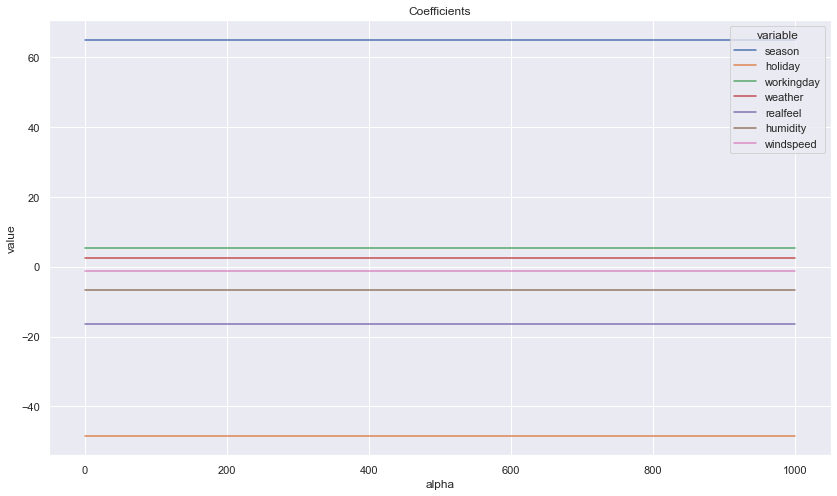

In [22]:
from helper_functions import ridge_coef_alpha_plot

ridge_coef_alpha_plot(X_train, X_val, y_train, y_val)

...hmmm not very useful in this case.

### Lasso Regression

In [23]:
# TODO: INSERT LASSO STUFF

#### Lasso $\beta$s as a function of $\alpha$

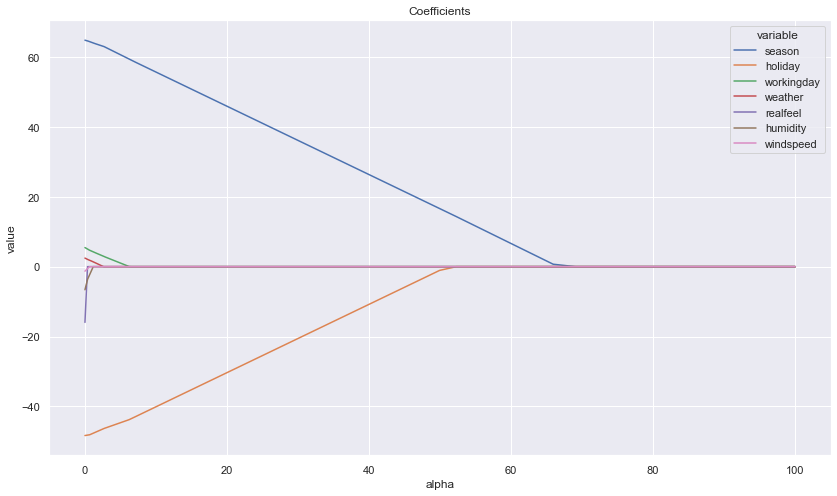

In [24]:
from helper_functions import lasso_coef_alpha_plot

lasso_coef_alpha_plot(X_train, X_val, y_train, y_val)

A useful feature of regularisation is it can help us understand which features were important for our model. As a coefficient being 0 means it is no longer being used, the coefficients that are reduced to 0 the slowest are the most important for the model, in this case `realfeel` and `humidity`.

### Advice for Applying Regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicollinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge Regression.